# Проект: Анализ A/B-теста новой платежной механики

Цель:

Оценить эффективность новой системы оплаты и принять решение о ее масштабировании на всех пользователей.

Задачи:

1. Сравнить ключевые бизнес-метрики между контрольной (базовая механика) и тестовой (новая механика) группами
2. Выявить статистическую значимость различий
3. Дать рекомендации по внедрению


# Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss 
import pingouin as pg 

In [2]:
# Таблица информацией о принадлежности пользователя к контрольной или экспериментальной группе 
# (А – контроль, B – целевая группа)
groups=pd.read_csv('groups.csv', sep=";")
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
# дополнительный файл с пользователями, который был прислан спустя 2 дня после передачи данных 

groups_add=pd.read_csv('group_add.csv')
groups_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [4]:
# Таблица с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

active_studs=pd.read_csv('active_studs.csv')
active_studs

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [5]:
# Таблица с информацией об оплатах пользователей в дни проведения эксперимента.

checks=pd.read_csv('checks.csv', sep=";")
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [6]:
# Объединяем группы с дополнительными данными
groups_new = pd.concat([groups, groups_add], ignore_index=True)
groups_new

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


Проверим на наличие дубликатов

In [7]:
groups_new.duplicated(subset='id').sum()

0

In [8]:
active_studs.duplicated().sum()

0

In [9]:
checks.duplicated(subset='student_id').sum()

0

Дубликаты отсутствуют. По таблице groups_new можно это дополнительно проверить, так как она состоит из двух таблиц: groups и присланной через 2 дня после первой groups_add. При мердже по общему ключу не должно быть пересечений (т.е. соответственно и дублей)

In [10]:
pd.merge(groups, groups_add, how='inner') 

,id,grp


Пересечений нет, значит, те же данные (те же - которые были и по какой-то причине решили отправить по ошибке повторно) нам не доотправляли и можно продолжить дальнейшую работу

Проверим на наличие пропущенных значений

In [11]:
groups_new.isna().sum()

id     0
grp    0
dtype: int64

In [12]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [13]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

Пропущенные значения также отсутствуют, значит, очистка на данном этапе не требуется

Проверим таблицы groups_new и checks на наличие аноималий или выбросов, а также распределение данных. active_studs на данный момент дополнительно проверять не требуется, так как содержит айдишники пользователей и предварительный анализ уже сделан

Для начала посмотрим на таблицу groups_new. Колонка id уже была проанализирована на пропуски и дубли, других проблем в этих данных пока что быть не может, поэтому сейчас больше всего интересует колонка grp, отвечающая за распределение пользователей к контрольной и тестовой группе. 

Группа А - контроль (текущая версия продукта - базовая механика оплаты услуг на сайте), 
В - тест (новая механика оплаты услуг на сайте)

In [14]:
groups_new.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

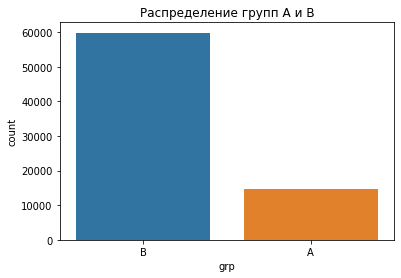

In [15]:
sns.countplot(data=groups_new, x='grp')
plt.title('Распределение групп A и B')
plt.show()

In [16]:
round(59883/14693,2)

4.08

Тестовая (экспериментальная) группа превышает контролоьную в 4 раза. A/B-тест с изменением механики оплаты — это критически важный эксперимент, так как платежи напрямую влияют на выручку. Для начала при серьезных изменениях рекомендуеся распределение 80% A / 20% B (или даже 90/10), так как в этом случае риск минимален, и вместо 80% выручки потеряется всего лишь (относительно) 10-20%. Для болеее подробного дальнейшего 
анализа не хватает данных по уровню отказов на шаге оплаты, но в рамках данного проекта, к сожалению, этих данных нет

Допускаю, что такое распределение было сделано целенаправленно для того, чтобы срок для сбора данных по новой версии был более быстрый, а также для лучшего понимания поведения пользователей, так как большая тестовая группа позволяет детальнее анализировать подгруппы (напрмер, как отреагируют новые или старые пользователи)

Далее рассмотрим подробнее таблицу, хранящую информацию о выручке

In [17]:
checks.rev.value_counts().sort_index(ascending=False)

4650.0000     1
3660.0000     5
3260.0000     1
3040.0000     1
2910.0000     4
2900.0000     1
2890.0000     4
2820.0000     2
2220.0000     2
2190.0000     1
2099.0000     3
1980.0000     4
1968.0000     1
1900.0001    36
1900.0000    97
1830.0000     1
1729.0000     1
1530.0000     8
1388.0000     1
1339.0000     1
1180.0000     2
1160.0000     3
1140.0000    25
1050.0000     1
1039.0000     1
990.0000     41
880.0000      1
870.0000      6
840.0000     27
796.0000      1
690.0000     78
630.0000      1
597.0000      1
590.0000     11
580.0000     15
489.0000      3
398.0000      9
290.0000     94
199.0000     46
Name: rev, dtype: int64

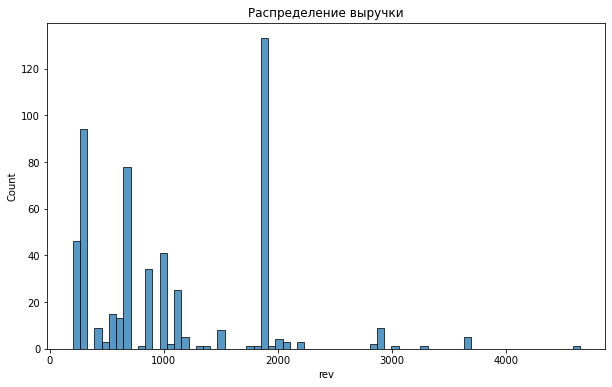

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(data=checks, x='rev', bins=70)
plt.title('Распределение выручки')
plt.show()

В данном случае 1900.0001 имеет ненулевое значение после 3-го знака в сравнении с остальными. Это не случайная погрешность, потому что остальные суммы (даже большие, вроде 4650.0000 или 3660.0000 ) имеют ровно четыре нуля.

Возможные причины:

- Ошибка в данных (например, при конвертации или загрузке).
- Форма данных (например, если данные приходят из разных источников, один из них мог добавить мусор: например, 1900 + случайный шум).
- Намеренное искажение (например, кто-то вручную изменил сумму, чтобы обойти проверки).
- Технический артефакт (например, ошибка округления в конкретном случае).

Что можно сделать в данном случае?
Стоит уточнить у поставщика, откуда берутся такие значения. Если мы будем уверены, что это случайная ошибка и изменить с 1900.0001 на 1900.0000. Пока на время выполнения анализа мы не уверены в природе аномалии и эту запись пока следует удалить для минимизации риска искажения статистики, так как замена требует обоснования, которого у нас пока нет. Если позже выяснится, что это была важная корректировка, можно вернуть данные. 

In [19]:
checkss = checks.query("rev != 1900.0001")
checkss

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [20]:
# Проверяем, что аномалии исчезли
checkss.rev.value_counts()

1900.0    97
290.0     94
690.0     78
199.0     46
990.0     41
840.0     27
1140.0    25
580.0     15
590.0     11
398.0      9
1530.0     8
870.0      6
3660.0     5
1980.0     4
2910.0     4
2890.0     4
2099.0     3
489.0      3
1160.0     3
1180.0     2
2220.0     2
2820.0     2
1050.0     1
597.0      1
630.0      1
2190.0     1
1830.0     1
1039.0     1
796.0      1
880.0      1
3040.0     1
3260.0     1
1968.0     1
1729.0     1
1388.0     1
2900.0     1
4650.0     1
1339.0     1
Name: rev, dtype: int64

Проверим согласованность данных между всеми таблицами

In [21]:
# Проверяем согласованность данных между checks и groups
# Сколько уникальных пользователей совершили оплаты (checks)
total_paying_users = checkss['student_id'].nunique()
print(f"Всего уникальных пользователей с оплатами (checkss): {total_paying_users}")

Всего уникальных пользователей с оплатами (checkss): 505


In [22]:
# Сколько из них есть в таблице групп (groups)
paying_users_in_groups = checkss['student_id'].isin(groups_new['id']).sum()
print(f"Из них распределены по группам A/B: {paying_users_in_groups}")

Из них распределены по группам A/B: 505


In [23]:
# Сколько оплативших пользователей НЕ распределено по группам
paying_users_not_in_groups = total_paying_users - paying_users_in_groups
print(f"Оплативших пользователей БЕЗ группы (A/B): {paying_users_not_in_groups}")

Оплативших пользователей БЕЗ группы (A/B): 0


Вывод показывает 0 - это означает, что все пользователи, совершившие оплату имеют соответствующую запись в таблице групп - данные согласованы.

Относительно этих двух таблиц проведём дополнительную проверку наоборот - есть ли пользоваели в таблице групп, но отсутствуют в таблице с информацией по оплате

In [24]:
users_in_groups_not_in_checks = ~groups_new['id'].isin(checkss['student_id'])
print(f"\nПользователей в groups_new, но не совершавших оплат (checkss): {users_in_groups_not_in_checks.sum()}")


Пользователей в groups_new, но не совершавших оплат (checkss): 74071


На следующем этапе необходимо соотнести полученные данные с таблицей, содержащей в себе информацию о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [25]:
# Количество пользователей, распределенных в разные группы
groups_new.shape[0]

74576

In [26]:
# Количество пользователей, совершивших оплату
checkss.shape[0]

505

In [27]:
# Количество пользователей, заходивших на платформу в момент проведения эксперимента
active_studs.shape[0]

8341

In [28]:
# Количество пользователей, заходивших на платформу в момент проведения эксперимента, 
# но не оплачивали либо информация об этом отсутствует
active_studs.shape[0]-checkss.shape[0]

7836

In [29]:
# Есть ли активные поьзователи, которые не попали ни в одну из групп? Должно быть 0
active_not_in_groups = ~active_studs['student_id'].isin(groups_new['id'])
print(f"Активных пользователей не в эксперименте (ошибка данных): {active_not_in_groups.sum()}")

Активных пользователей не в эксперименте (ошибка данных): 0


In [30]:
# Пользователи checks, не в active_studs (должно быть 0)
paying_not_active = ~checkss['student_id'].isin(active_studs['student_id'])
print(f"Платящих пользователей не в active_studs: {paying_not_active.sum()}")

Платящих пользователей не в active_studs: 148


Согласно изначалььным данным, в таблице checks должна содержаться информация об оплатах пользователей в дни проведения эксперимента, то есть пользователь должен был заходить на платформу в дни проведения эксперимента

In [31]:
# Выделяем проблемные записи для анализа
problematic_payments = checkss[~checkss['student_id'].isin(active_studs['student_id'])]

print(f"Обнаружено {len(problematic_payments)} оплат от пользователей, не учтённых в active_studs")
print("Статистика по суммам этих оплат:")
print(problematic_payments['rev'].describe())

Обнаружено 148 оплат от пользователей, не учтённых в active_studs
Статистика по суммам этих оплат:
count     148.000000
mean      700.216216
std       366.963223
min       199.000000
25%       290.000000
50%       690.000000
75%       990.000000
max      1980.000000
Name: rev, dtype: float64


In [32]:
# Количество пользователей, информация о которых есть в обеих таблицах, 
# отвечающих за наличие данных в момент проведения эксперимента
checkss.shape[0]-paying_not_active.sum()

357

Таким образом, после проведения предварительного анализа, можно собрать единую таблицу, в которой будут все и только нужные данные для дальнейшей работы по подбору метрик и проведения статистического анализа

In [33]:
table_1=pd.merge(active_studs, checkss, on='student_id', how='left')

Объединение талицы active_studs с checks по столбцу student_id.

how='left' означает, что в результирующем DataFrame останутся все строки из active_studs, даже если в checks нет соответствия.

Если у пользователя нет записей в checks, соответствующие поля будут заполнены NaN.

In [34]:
general_table=pd.merge(table_1, groups_new, left_on='student_id', right_on='id', how='left')

К результату предыдущего шага добавляется информация из groups.

left_on='student_id' – столбец из левого DataFrame (результата предыдущего слияния), по которому идёт соединение.

right_on='id' – столбец из правого DataFrame (groups_new), по которому идёт соединение.

how='left' – сохраняются все записи из левой таблицы, даже если в groups_new нет соответствия.

Если пользователь не состоит ни в одной группе, соответствующие поля будут NaN.

In [35]:
general_table=general_table.drop(columns=['id'])
general_table

,student_id,rev,grp
0,581585,NaN,A
1,5723133,NaN,A
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B
...,...,...,...
8336,1794344,NaN,B
8337,296883,NaN,B
8338,3598448,NaN,B
8339,3610547,290.0,B


In [36]:
# Заменим NaN в revenue на 0 для пользователей без оплат
general_table['rev'] = general_table['rev'].fillna(0)
general_table

,student_id,rev,grp
0,581585,0.0,A
1,5723133,0.0,A
2,3276743,0.0,B
3,4238589,0.0,A
4,4475369,0.0,B
...,...,...,...
8336,1794344,0.0,B
8337,296883,0.0,B
8338,3598448,0.0,B
8339,3610547,290.0,B


Для последующего анализа в таблицу general_table было отобрано 8341 только активных пользователей, распределенных на группы, среди которых 357 совершали покупки в момент проведения эксперимена.

Проверим, как теперь после проведения предобработки как распределились пользователи по группам

In [37]:
general_table.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

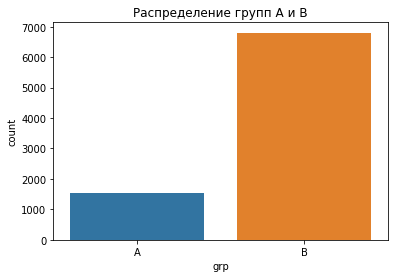

In [38]:
sns.countplot(data=general_table, x='grp')
plt.title('Распределение групп A и B')
plt.show()

In [39]:
round(6803/1538,2)

4.42

Соотношение групп чуть увеличено, чем в изначальной таблице и составляет 1 к 4.4

# Определение метрик

CR (Conversion Rate), или коэффициент конверсии — это процент пользователей, совершивших хотя бы одну оплату, от общего числа посетителей.

Обоснование выбора:
- чувствительность: CR чувствительна, так как прямо реагирует на изменения в процессе оплаты: если механика действительно упрощает оплату, CR покажет рост сразу после внедрения. 
    - возможные ограничения - краткосрочные акции могут временно исказить CR, поэтмоу важно проводить тесты, когда акции отсутствуют
- достоверность: CR достоверна так как основана на фактических платежах (не на опросах или намерениях) и легко верифицировать (данные из checks (список оплат) можно сопоставить с active_studs (активные пользователи))
- интерпретируемость: CR интерпретируема, так как есть прямая связь с бизнес-результатом: рост CR на 1% = на 1% больше пользователей начали платить, а так же она проста в понимании-даже нетехнические специалисты видят, что "чем выше CR, тем лучше".

также хочется добавить ещё несколько критериев:

1 критерий - связь с бизнес-целью. это важно, так как метрика напрямуб влияет на KPI компаний. метрика CR отвечает на вопрос "Стало ли больше пользователей платить?". Цель - увеличение клиентской базы

2 критерий - устойчивость к искажениям. CR может быть искажена, если в одной группе случайно оказались больше "холодных" пользователей. Решение - проверять баланс групп по источникам трафик. 

ARPPU (Average Revenue Per Paying User) - средний доход с платящего пользователя. Фокусируется исключительно на клиентах, совершивших покупку. ARPPU помогает понять, сколько в среднем приносит каждый платящий пользователь. Это важно для оценки эффективности конверсии пользователей в платящих и понимания поведения пользователей. 

Обснование выбора:
- чувствительность: ARPPU хорошо отражает изменения в платежном поведении пользователей, так как: Чувствителен к изменениям в ценовой политике (скидки, новые тарифы), реагирует на улучшения платежного интерфейса (упрощение процесса оплаты), показывает эффект от таргетированных предложений (например, премиум-услуг)
- достоверность: метрика достоверна, так как устойчива к неоплатившим пользователям (в отличие от ARPU, который "размывается" нулями) и позволяет четко измерить реальный экономически эффект от изменений
- интерпретируемость: метрика понятна бизнесу - "Средний платеж одного оплатившего пользователя", а так же прямо связана с выручкой: Общая выручка = ARPPU * Количество оплативших

и также по критериям:

1 критерий - связь с бизнес-целью. ARPPU отвечает на вопрос "Стали ли пользователи больше платить?". Цель - рост среднего чека и выручки. Если бизнес хочет увеличить доход, но СR уже высокий, тогда следующей приоритетной метрикой становится ARPPU

2 критерий - устойчивость к искажениям. ARPPU может быть искажена выбросами (один крупный платеж меняет среднее). Решение - дополнительно смотреть медиану.

Почему в решении 2 критерия нужно дополнительно смотреть на медиану. 

Данные о платежах часто имеют правостороннюю асимметрию (большинство платежей небольшие, но есть несколько очень крупных). Медиана - устойчивая мера центральной тенденции, которая не чувствительна к выбросам (в отличие от среднего) и показывает "типичный" платеж, который ожидается от большинства пользователей.

Так, было выбрано CR и ARPPU, так как они взаимодополняют друг друга: CR показывает, как новая механика привлекает новых плательщиков, а ARPPU — как она влияет на их платежеспособность. Обе метрики соответствуют критериям чувствительности, достоверности и интерпретируемости, а их ограничения контролируются через анализ распределений и баланс групп.

Посмотрим на метрики в разрезе групп


Конверсия в оплату по группам:
grp
A    5.07%
B     4.1%
Name: rev, dtype: object


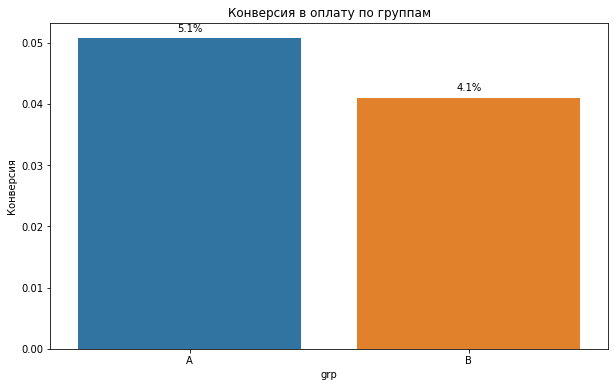

In [40]:
conversion_rate = general_table.groupby('grp')['rev'].apply(lambda x: (x > 0).mean())
print("\nКонверсия в оплату по группам:")
print((conversion_rate * 100).round(2).astype(str) + '%')

# Визуализация 
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=conversion_rate.index, y=conversion_rate.values)
plt.title('Конверсия в оплату по группам')
plt.ylabel('Конверсия')

for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
    
plt.show()

ARPPU по группам:
      ARPPU_mean  ARPPU_median  paying_users_count
grp                                               
A     933.589744         585.0                  78
B    1177.326165         990.0                 279


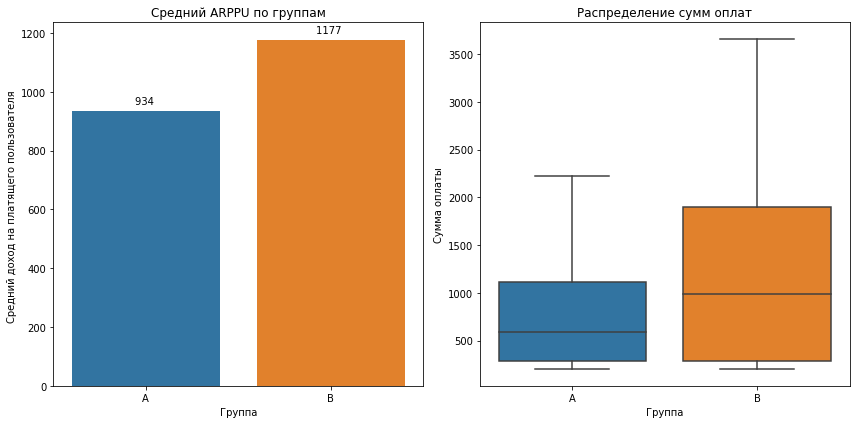

In [41]:
paying_users = general_table[general_table['rev'] > 0].copy()
arppu = paying_users.groupby('grp')['rev'].agg(['mean', 'median', 'count'])
arppu.columns = ['ARPPU_mean', 'ARPPU_median', 'paying_users_count']
print("ARPPU по группам:")
print(arppu)

# Визуализация
plt.figure(figsize=(12, 6))

# График среднего ARPPU 
plt.subplot(1, 2, 1)
ax1 = sns.barplot(
    data=paying_users, 
    x='grp', 
    y='rev', 
    estimator=np.mean,
    ci=None
)
plt.title('Средний ARPPU по группам')
plt.ylabel('Средний доход на платящего пользователя ')
plt.xlabel('Группа')

# Добавляем точные значения на столбцы
for p in ax1.patches:
    ax1.annotate(
        f'{p.get_height():.0f} ', 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        xytext=(0, 10), 
        textcoords='offset points'
    )

# График распределения сумм оплат
plt.subplot(1, 2, 2)
sns.boxplot(
    data=paying_users, 
    x='grp', 
    y='rev', 
    showfliers=False  
)  
plt.title('Распределение сумм оплат')
plt.ylabel('Сумма оплаты')
plt.xlabel('Группа')

plt.tight_layout()
plt.show()

1. CR (Conversion Rate) Конверсия в оплату

Группа A: 5.07%

Группа B: 4.1%

Наблюдение:

Конверсия в группе B ниже на 0.97 п.п. (19% относительного снижения). Возможные причины:

- Новая механика оплаты могла усложнить процесс для части пользователей

- В группе B могло оказаться больше "холодных" пользователей

- Технические ошибки при внедрении новой механики

Важно проверить:

- Статистическую значимость различий 

- Распределение пользователей по источникам трафика/сегментам

2. ARPPU (Average Revenue Per Paying User) средни доход с платящего пользователя

Рост среднего чека на 26%:

- Пользователи группы B в среднем платят больше

- Возможно, новая механика стимулирует более дорогие покупки

Ещё более сильный рост медианы (69%):

- У большинства платящих пользователей чек вырос существенно

- Медиана менее чувствительна к выбросам, чем среднее

Разрыв между средним и медианой:

- В группе A: среднее (933.6) > медиана (585) - есть редкие крупные платежи

- В группе B: разрыв меньше - распределение платежей более однородное

# Статистический анализ

Описательная статистика

In [42]:
# Для всех пользователей (включая неоплативших)
desc_stats_all = general_table.groupby('grp').rev.describe()
print("Статистика по всем пользователям:")
print(desc_stats_all)

Статистика по всем пользователям:
      count       mean         std  min  25%  50%  75%     max
grp                                                           
A    1538.0  47.347204  290.490632  0.0  0.0  0.0  0.0  3660.0
B    6803.0  48.283698  284.457342  0.0  0.0  0.0  0.0  4650.0


In [43]:
# Только для платящих пользователей
desc_stats_paying = general_table[general_table['rev'] > 0].groupby('grp').rev.describe()
print("\nСтатистика для платящих пользователей:")
print(desc_stats_paying)


Статистика для платящих пользователей:
     count         mean         std    min    25%    50%      75%     max
grp                                                                      
A     78.0   933.589744  919.932711  199.0  290.0  585.0  1114.75  3660.0
B    279.0  1177.326165  803.610099  199.0  290.0  990.0  1900.00  4650.0


In [44]:
# 1 Общие показатели
control=round((78/1538)*100,2)
test=round((279/6803)*100,2)
print(f"Конверсия в группе А равна {control} %, а в группе В {test} %")

Конверсия в группе А равна 5.07 %, а в группе В 4.1 %


В группе B конверсия ниже, несмотря на новую механику оплаты. 
Возможные причины: 
- Неравномерное распределение пользователей (в группе B в 4.4 раза больше пользователей)
- Различия в сегментации (например, группа B могла получить больше "холодных" пользователей)

2. Анализ платящих пользователей

Контрольная группа А:

Средний чек 933.589744, медианный 585.0. Медиана значительно ниже среднего. Это указывает на правостороннюю асимметрию, когда длинный хвост крупных платежей смещает данные.

Тестовая группа В:

Средний чек 1177.326165, медианный  990.0. Медиана ближе к среднему, распределение более сбалансированное.

Новая механика оплаты значительно увеличила средний и медианный чек, возможно за счет снижения конверсии

3. Распределение платежей

Стандартное отклонение (std) от среднего для каждой группы
Контрольная группа А std = 919.932711
Тестовая группа В std = 803.610099

Для группы А:
    стандартное отклонение почти равно среднему, очень большой разброс данных. Много платежей значительно отличаются от среднего. Есть как очень маленькие (199) так и большие (3660) платежи
    
Для группы В:
    стандартное отклонение меньше среднего, возможно, это влиние новой механики оплаты, поэтому платежи относительно А более стабильные. Экстремальных отклонений меньге, хотя разброс всё ещё очень большой (199-4650)


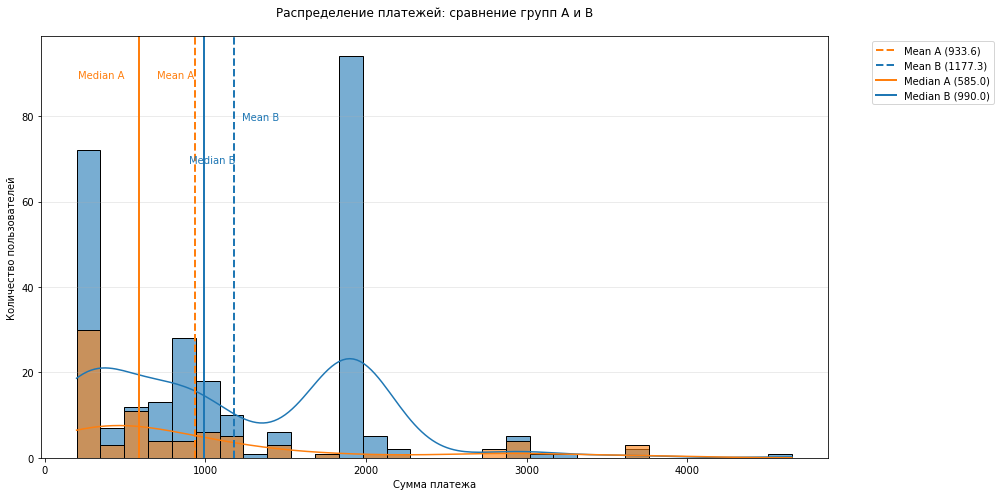

In [45]:

paying_users = general_table[general_table['rev'] > 0]

median_a = paying_users[paying_users['grp'] == 'A']['rev'].median()
median_b = paying_users[paying_users['grp'] == 'B']['rev'].median()

plt.figure(figsize=(14, 7))
ax = sns.histplot(
    data=paying_users, 
    x='rev', 
    hue='grp', 
    bins=30, 
    kde=True, 
    alpha=0.6,
    palette=['#ff7f0e', '#1f77b4']  # Оранжевый - A, синий - B
)


plt.axvline(x=933.6, color='#ff7f0e', linestyle='--', linewidth=2, label='Mean A (933.6)')
plt.axvline(x=1177.3, color='#1f77b4', linestyle='--', linewidth=2, label='Mean B (1177.3)')

plt.axvline(x=median_a, color='#ff7f0e', linestyle='-', linewidth=2, label=f'Median A ({median_a:.1f})')
plt.axvline(x=median_b, color='#1f77b4', linestyle='-', linewidth=2, label=f'Median B ({median_b:.1f})')

plt.title('Распределение платежей: сравнение групп A и B', pad=20)
plt.xlabel('Сумма платежа')
plt.ylabel('Количество пользователей')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.text(933.6 , ax.get_ylim()[1]*0.9, 'Mean A', color='#ff7f0e', ha='right')
plt.text(1177.3 + 50, ax.get_ylim()[1]*0.8, 'Mean B', color='#1f77b4', ha='left')
plt.text(median_a - 90, ax.get_ylim()[1]*0.9, f'Median A', 
         color='#ff7f0e', ha='right')
plt.text(median_b + 200, ax.get_ylim()[1]*0.7, f'Median B', 
         color='#1f77b4', ha='right')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Выбор статистического теста для оценки статистической значимости.

Выбор среди двухвыборочных тестов.

Сравнивают средние двух выборок.

- t-критерий Стьюдента для независимых выборок

   - Условия:

       - Независимые выборки.

       - Нормальное распределение или большой объем выборки.

       - Проверка равенства дисперсий (критерий Левена или F-тест).

   - Варианты:

       - С равными дисперсиями (критерий Стьюдента).

       - С неравными дисперсиями (критерий Уэлча).

- t-критерий Стьюдента для парных выборок

   - Условия:

       - Зависимые выборки (например, до и после воздействия).

       - Разности пар должны быть нормально распределены.

- U-критерий Манна-Уитни (непараметрический аналог t-теста)

   - Условия:

       - Ненормальное распределение.

       - Независимые выборки.

   - Проверяет гипотезу о равенстве медиан или сдвиге распределений.

- Критерий Уилкоксона (парный непараметрический тест)

   - Аналог парного t-теста для ненормальных данных.
   

Для достоверной оценки статистической значимости необходимо выбрать правильно тест. 

t-критерий Стьюдента для парных выборок уже не подходит, так как выборки не зависимы медлу собой, поэтому выбираем между:

t-критерий Стьюдента для независимых выборок, U-критерий Манна-Уитни (непараметрический аналог t-теста) и Критерий Уилкоксона (парный непараметрический тест, аналог парного t-теста для ненормальных данных). 

Согласно условиям t-критерий Стьюдента для независимых выборок (а выборки в нашем случае друг от лруга независимы, значит первое условие уже выполнено), нужно провести проверку распределения данных на нормальность и провести проверку равенства дисперсий (критерий Левена или F-тест).


U-критерий Манна-Уитни (непараметрический аналог t-теста) - выборки независимы, поэтому также как и с Т-тестом нужно проверить нормальность распределения данных.

Критерий Уилкоксона (парный непараметрический тест) - данные распределены ненормально либо это неизвестно.


Для проверки на нормальность распределения данных применим статистический тест Шапиро-Уилка.

Нулевая гипотеза данные распределены нормально. 

Альтернативная гипотеза данные распределены ненормально.

Если p-значение < 0,05 (5%), нулевая гипотеза отвергается, распределение не является нормальным.

In [46]:
group_a = general_table[(general_table['grp'] == 'A') & (general_table['rev'] > 0)]['rev']
group_b = general_table[(general_table['grp'] == 'B') & (general_table['rev'] > 0)]['rev']

In [47]:
from scipy.stats import shapiro  
stat_a, p_a=shapiro(group_a)
stat_a, p_a

(0.7353236079216003, 1.4986822893803264e-10)

In [48]:
stat_b, p_b=shapiro(group_b)
stat_b, p_b

(0.8672734498977661, 8.787840619854225e-15)

In [49]:
print(f"""
Результаты теста Шапиро-Уилка:

Группа A:
- Статистика: {stat_a:.4f}
- p-value: {p_a:.4f}
- Нормальность: {'Распределение нормально' if p_a > 0.05 else 'Распределение не нормально'}

Группа B:
- Статистика: {stat_b:.4f}
- p-value: {p_b:.4f}
- Нормальность: {'Распределение нормально' if p_b > 0.05 else 'Распределение не нормально'}
""")


Результаты теста Шапиро-Уилка:

Группа A:
- Статистика: 0.7353
- p-value: 0.0000
- Нормальность: Распределение не нормально

Группа B:
- Статистика: 0.8673
- p-value: 0.0000
- Нормальность: Распределение не нормально



В результате теста Шапиро-Уилка принимается альтернативная гипотеза о ненормальности данных во всех группах, так как и p-значение < 0,05 и статистика, измеряющая степень отклонения от нормального меньше единицы.



Теперь перейдем к проверке условия равенства дисперсий.

Критерии для проверки гипотез о дисперсиях

- F-тест (критерий Фишера)

  - Сравнивает дисперсии двух выборок.

  - Условия: нормальное распределение.

- Критерий Бартлетта / Левена

  - Проверяет равенство дисперсий нескольких выборок.

  - Бартлетт чувствителен к отклонениям от нормальности, Левен более устойчив
  
На основе теоретической справки, для проверки равенства дисперсий будем использовать критерий Левена, так как распределение данных ненормально.

Нулевая гипотеза - дисперсии двух групп равны

Альтернативная гипотеза - дисперсии двух групп не равны

In [55]:
from scipy.stats import levene

In [56]:
# Выделяем данные по группам (только платящие пользователи)
group_a_l = general_table[(general_table['grp'] == 'A') & (general_table['rev'] > 0)]['rev']
group_b_l = general_table[(general_table['grp'] == 'B') & (general_table['rev'] > 0)]['rev']


In [57]:
# Проводим тест Левена
stat, p_value = levene(group_a, group_b, center='median')  # Используем медиану как центр (более устойчивый вариант)

In [58]:
print(f"""Результаты теста Левена:
- Статистика: {stat:.4f}
- p-value: {p_value:.4f}
- Заключение: {'Не отвергаем H₀ (дисперсии равны)' if p_value > 0.05 else 'Отвергаем H₀ (дисперсии различаются)'}
""")

Результаты теста Левена:
- Статистика: 1.6546
- p-value: 0.1992
- Заключение: Не отвергаем H₀ (дисперсии равны)



Продублирую ещё раз тесты и условия их выбора:
- t-критерий Стьюдента для независимых выборок

   - Условия:

       - Независимые выборки.

       - Нормальное распределение или большой объем выборки.

       - Проверка равенства дисперсий (критерий Левена или F-тест).

   - Варианты:

       - С равными дисперсиями (критерий Стьюдента).

       - С неравными дисперсиями (критерий Уэлча).
 - U-критерий Манна-Уитни (непараметрический аналог t-теста)

   - Условия:

       - Ненормальное распределение.

       - Независимые выборки.

   - Проверяет гипотезу о равенстве медиан или сдвиге распределений.

- Критерий Уилкоксона (парный непараметрический тест)

   - Аналог парного t-теста для ненормальных данных.
         
         
Что мы имеем: ненормальное распределение данных, дисперсии равны. 

t-тест устойчив к отклонениям от нормальности, если:

- Размер выборки достаточно большой (обычно n>=30 для каждой группы).

В нашем случае:


Группа A: 78 пользователей.


Группа B: 279 пользователей.


Условие выполняется.

Распределения не сильно искажены, так как ранее удалили аномалии (rev = 1900.0001), поэтому проблема минимизирована

Поэтому для проверки статистической значимости будем использовать - t-критерий Стьюдента для независимых выборок (критерий Стьюдента так как дисперсии равны)


Ранее были выбраны две мерки для проверки - CR и ARPPU

Сформулируем гипотезы для Conversion Rate (CR):

Нулевая гипотеза - конверсия в группах А и В одинакова

Альтернативная гипотеза - конверсия в группах А и В различается

In [59]:
cr_data = general_table.assign(converted=lambda x: (x['rev'] > 0).astype(int))
cr_test = pg.ttest(
    x=cr_data[cr_data['grp'] == 'A']['converted'],
    y=cr_data[cr_data['grp'] == 'B']['converted'],
    correction=False)  # Поправка Уэлча не нужна, т.к. дисперсии равны


Сформулируем гипотезы для метрики ARPPU (только платящие пользователи):

Нулевая гипотеза - Средний доход на платящего пользователя в группах А и В одинаковый

Альтернативная гипотеза - Средний доход на платящего пользователя в группах А и В различается

In [67]:
paying_users = general_table[general_table['rev'] > 0]
arppu_test = pg.ttest(
    x=paying_users[paying_users['grp'] == 'A']['rev'],
    y=paying_users[paying_users['grp'] == 'B']['rev'],
    correction=False)

In [68]:
print("Результаты t-теста для Conversion Rate:")
print(" ")
print(cr_test.round(4))
print(" ")
print(" ")
print("\nРезультаты t-теста для ARPPU:")
print(" ")
print(arppu_test.round(4))

Результаты t-теста для Conversion Rate:
 
             T   dof alternative   p-val         CI95%  cohen-d   BF10   power
T-test  1.6981  8339   two-sided  0.0895  [-0.0, 0.02]   0.0479  0.134  0.3968
 
 

Результаты t-теста для ARPPU:
 
             T  dof alternative   p-val              CI95%  cohen-d   BF10  \
T-test -2.2921  355   two-sided  0.0225  [-452.86, -34.61]   0.2936  1.664   

         power  
T-test  0.6278  


Объяснение полученных результатов

Conversion Rate (CR):

- Статистическая значимость: p-value = 0.0895 (> 0.05) - нет статистически значимых различий в конверсии между группами.
- Размер эффекта: Cohen's d = 0.0479 (< 0.2 — эффект отсутствует) - Даже если бы p-value был значимым, разница минимальна.
- Доверительный интервал: CI95% включает 0 (от -0.0 до 0.02)- разница может колебаться от нуля до 2% в пользу группы B.

Вывод: новая механика оплаты не повлияла на вероятность совершения платежа пользователями.


ARPPU (Average Revenue Per Paying User):

- Статистическая значимость: p-value = 0.0225 (< 0.05) - различия статистически значимы.
- Размер эффекта: Cohen's d = 0.2936 (~ 0.3 — малый эффект) - практическая значимость под вопросом.
- Доверительный интервал: CI95% = [- 452.86, - 34.61]  - средний чек в группе B выше на 35–453, чем в группе A.

Вывод: новая механика оплаты немного увеличила средний чек, но эффект имеет малый размер и практическая значимость 

Новая механика оплаты не повлияла на конверсию (p = 0.089), но увеличила средний чек на 35–453 (p = 0.022). Однако эффект мал (Cohen's d = 0.29), и решение о запуске должно учитывать:

- Окупаемость внедрения
- Долгосрочную стабильность эффекта. Рекомендуется расширить период тестирования.

По текущим полученным результатам внедрять новую механику оплаты не рекомендуется.